In [82]:
"""Librairies nécessaires"""

import pandas as pd
from pandas import json_normalize
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt

import json

import geopy.distance
from geopy.distance import geodesic as GD

from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

from tqdm import tqdm

!pip install unidecode
from unidecode import unidecode

!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

In [83]:
"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-Stat-App-2A')

In [84]:
"""Lecture du fichier des lieux touristiques et des monuments"""

emplacement_tour = '3.0) Enrichissement données/Données/Principaux_sites_touristiques_idf.geojson'
df_sites_tour = gpd.read_file(emplacement_tour, low_memory=False, index_col=0)

In [85]:
#restriction à Paris
df_sites_tour_paris = df_sites_tour.loc[df_sites_tour['dep']=='75']

In [86]:
#observation des types de sites
df_sites_tour_paris['typo_niv3'].unique()

array(["Centre de congrès et parc d'exposition", 'Musée et écomusée',
       'Site et monument',
       'Haltes, escales ou ports fluviaux de plaisance',
       "Offices du tourisme et syndicats d'initiative",
       'Espace de loisirs, espace récréatif',
       'Diffusion du spectacle vivant',
       "Diffusion de l'art (autre que musée)"], dtype=object)

In [87]:
#restriction selon le type

type_interet = ["Centre de congrès et parc d'exposition", 'Musée et écomusée',
       'Site et monument', 'Espace de loisirs, espace récréatif']

df_sites_tour = df_sites_tour_paris.loc[df_sites_tour_paris['typo_niv3'].isin(type_interet)]

In [88]:
#modifier la colonne geometry

# Fonction pour extraire les coordonnées et créer un objet Point
def create_point_geometry(row):
    lon = row['geo_point_2d']['lon']
    lat = row['geo_point_2d']['lat']
    return Point(lon, lat)

# Appliquer la fonction à la colonne 'geo_point_2d' pour créer la colonne 'geometry'
df_sites_tour['geometry'] = df_sites_tour.apply(create_point_geometry, axis=1)

# Convertir en GeoDataFrame
df_sites_tour = gpd.GeoDataFrame(df_sites_tour, geometry='geometry', crs='EPSG:4326')

/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [89]:
#nombre de sites sélectionnés
df_sites_tour.shape

(237, 9)

In [90]:
"""Chargement des données administratives de Paris intra muros"""

paris_arrondissement = gpd.read_file('2) Visualisation/Données_carto/paris_arrondissements.geojson')

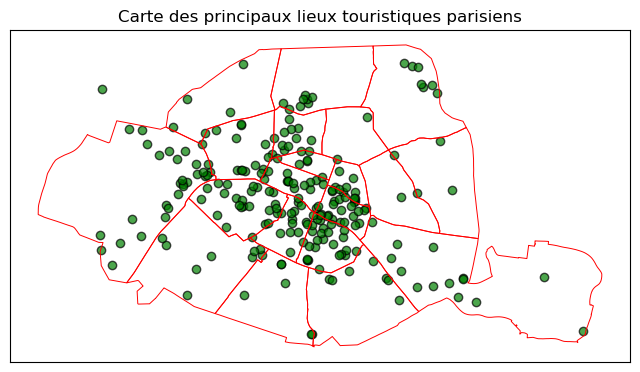

In [91]:
"""Visualisation des lieux touristiques"""

fig, ax = plt.subplots(figsize=(8, 7))

paris_arrondissement.boundary.plot(ax=ax, edgecolor = "red", linewidth = 0.7) #on ajout les arrondissements parisiens en rouge

df_sites_tour.plot(ax=ax, color='green', alpha=0.7, edgecolor='black', linewidth=1) #on ajoute les lycées

#rien sur les axes
plt.xticks([], [])
plt.yticks([], [])

#titre
plt.title('Carte des principaux lieux touristiques parisiens')
plt.savefig('3.0) Enrichissement données/Sorties_cartes/carte_lieux_touristiques_paris.png')
plt.show()

In [98]:
"""Fonction qui ajoute aux appartements le lieu touristique le plus proche"""

def ajouter_sites_tour(dvf, df_sites_tour):
    
    #dvf : geodataframe contenant la localisation de l'appartement dans une colonne 'geometry' au format WSG84
    #df_sites_tour : geodataframe contenant la localisation des sites touristiques dans une colonne 'geometry' au format WSG84

    #la fonction ajoute trois colonnes à dvf : closest_site_tour, dist_min_site_tour
    
    # Convertir la colonne 'geometry' en type Point
    #dvf['geometry'] = dvf['geometry'].apply(Point)
    #df_sites_tour['geometry'] = df_sites_tour['geometry'].apply(Point)
    
    # Définir la projection équidistante (EPSG:3395)
    dvf = dvf.to_crs(epsg=3395)
    df_sites_tour = df_sites_tour.to_crs(epsg=3395)
        
    # Fonction pour trouver la station de métro la plus proche
    def find_nearest_site_tour(row):
        nearest_site_tour = df_sites_tour.geometry == nearest_points(row['geometry'], df_sites_tour.unary_union)[1]
        return pd.Series({
            'closest_site_tour': df_sites_tour.loc[nearest_site_tour, 'nom_carto'].values[0],
            'dist_min_site_tour': row['geometry'].distance(df_sites_tour.loc[nearest_site_tour, 'geometry'].values[0]) / 1000,  # Conversion en kilomètres
        })
    
    # Appliquer la fonction pour chaque appartement
    tqdm.pandas()  # Barre de progression pour les itérations
    dvf[['closest_site_tour', 'dist_min_site_tour']] = dvf.progress_apply(find_nearest_site_tour, axis=1)

    # Reconvertir en WGS 84 (EPSG:4326)
    dvf_result = dvf.to_crs(epsg=4326)
    
    return dvf_result

In [102]:
"""Chargement fichier dvf"""

#chemin du fichier dvf
path_folder = '1.2) Données_concat/'
name_file = 'dvf_concat_2021_to_2023.geojson'
path_file = path_folder + name_file

#lecture du fichier dvf
dvf = gpd.read_file(path_file)

#chemin export
outer_path = '3.1) Données_enrichies/'

In [103]:
"""Fonction qui applique ajouter_sites_tour et exporte le fichier"""

def ajout_site_tour_export(dvf, outer_path):

    #on applique la fonction ajouter_sites_tour
    dvf_enrichi = ajouter_sites_tour(dvf, df_sites_tour)

    #nom du fichier de sortie
    name_file_without_extension = os.path.splitext(name_file)[0]
    outer_name = f'{name_file_without_extension}_avec_sites_tour.geojson'

    #on exporte
    dvf_enrichi.to_file(outer_path+outer_name, driver='GeoJSON')

    return dvf_enrichi

In [104]:
"""Ajouter les lieux touristiques au fichier dvf"""

dvf_enrichi = ajout_site_tour_export(dvf, outer_path)

100%|██████████| 59417/59417 [10:39<00:00, 92.93it/s] 
